In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
folder_path = "phase_and_aperture"
os.makedirs(folder_path, exist_ok=True)

In [3]:
plt.rcParams['font.family'] = 'STIXGeneral'

In [4]:
periodicity = 0.0056 #Periodicity of metalens scatterers, in mm

Functions for generating aperture and phase

In [5]:
## Function to define the golay aperture's coordinates
def get_golay_coords(order):
    s3 = np.sqrt(3)
    if order == 1:
        coords = np.array([[0, 0]])
    elif order == 3:
        coords = np.array([[-1/2, -s3/6], [1/2, -s3/6], [0, s3/3]])
    elif order == 6:
        d = 1
        coords = np.array([[0, 0], [d, 0], [-d/2, -d*s3/2], [d/2, -d*s3/2],
                           [3*d/2, -d*s3/2], [-d, -d*s3], [0, -d*s3], [d, -d*s3],
                           [2*d, -d*s3], [-d/2, -3*d*s3/2], [d/2, -3*d*s3/2],
                           [3*d/2, -3*d*s3/2]])
        coords = coords[[1, 2, 4, 5, 10, 11], :]
    elif order == 9:
        coords = np.array([[-1/2, -s3/6], [1/2, -s3/6], [0, s3/3], [7/2, -s3/6],
                           [3/2, 5*s3/6], [-3/2, 11*s3/6], [-2, s3/3],
                           [-2, -5*s3/3], [1/2, -7*s3/6]])
    center = np.mean(coords, axis=0)
    coords = coords - center
    return coords

In [6]:
## Function to generate the Golay aperture, given the order, the sub aperture radius, the circumscribe radius, the grid
## Add center = true if the central sub-aperture is included
def golay(order, r, circumradius, dx, add_center):

    coords = get_golay_coords(order) * 4 * r

    if add_center:
        coords = np.vstack((coords, np.array([0., 0.])))

    relaxation = (circumradius - r) / (np.max(np.hypot(coords[:, 0], coords[:, 1])))
    coords *= relaxation

    xmin = np.min(coords[:, 0])
    xmax = np.max(coords[:, 0])
    ymin = np.min(coords[:, 1])
    ymax = np.max(coords[:, 1])

    amin = min(xmin, ymin) - r
    amax = max(xmax, ymax) + r

    radii = np.hypot(coords[:, 0], coords[:, 1])
    amin = -max(radii) - r
    amax = max(radii) + r

    X, Y = np.meshgrid(np.arange(amin, amax+dx, dx), np.arange(amin, amax+dx, dx))
    # X, Y = np.meshgrid(np.arange(amin, amax, dx), np.arange(amin, amax, dx))

    aperture = np.zeros_like(X)

    for idx in range(order + int(add_center)):
        center = coords[idx, :]
        aperture += ((X - center[0])**2 + (Y - center[1])**2 < r**2)
        
    return coords, aperture

In [7]:
## Function to generate a hyperboloid phase mask inside a circular aperture
def generate_hyperboloid_phase_mask(periodicity=0.002, semi_diameter=44.5, wavelength=4.50e-3, f=356):

    x = np.arange(0, semi_diameter, periodicity)
    y = np.arange(0, semi_diameter, periodicity)
    xx, yy = np.meshgrid(x, y)

    k = 2 * np.pi / wavelength
    D = 2 * semi_diameter
    rho = np.sqrt(xx ** 2 + yy ** 2)

    ## Generate a quarter circularized phase mask and amplitude mask in hyperboloid phase profile
    quarter_circularized_phase = -((k * (np.sqrt((rho) ** 2 + f ** 2) - f))) % (2 * np.pi)
    quarter_circularized_aperture = np.ones_like(quarter_circularized_phase)
    condition = xx ** 2 + yy ** 2 <= semi_diameter ** 2 # Apply condition to set values outside the quarter circle to zero
    quarter_circularized_phase[~condition] = 0
    quarter_circularized_aperture[~condition] = 0

    arraylen = len(quarter_circularized_phase)

    ## Convert the quarter-circular phase and amplitude masks into full-circular masks.

    phasefield = np.zeros((2*arraylen,2*arraylen))
    phasefield[0:arraylen,0:arraylen] = np.fliplr(np.flipud(quarter_circularized_phase))
    phasefield[0:arraylen,arraylen:2*arraylen] = np.flipud(quarter_circularized_phase)
    phasefield[arraylen:2*arraylen,0:arraylen] = np.fliplr(quarter_circularized_phase)
    phasefield[arraylen:2*arraylen,arraylen:2*arraylen] = quarter_circularized_phase

    circular_aperture = np.zeros((2*arraylen,2*arraylen))
    circular_aperture[0:arraylen,0:arraylen] = np.fliplr(np.flipud(quarter_circularized_aperture))
    circular_aperture[0:arraylen,arraylen:2*arraylen] = np.flipud(quarter_circularized_aperture)
    circular_aperture[arraylen:2*arraylen,0:arraylen] = np.fliplr(quarter_circularized_aperture)
    circular_aperture[arraylen:2*arraylen,arraylen:2*arraylen] = quarter_circularized_aperture

    return phasefield, circular_aperture


Center Aperture (8 mm radius)

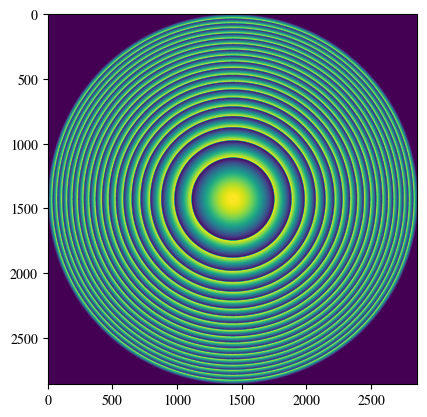

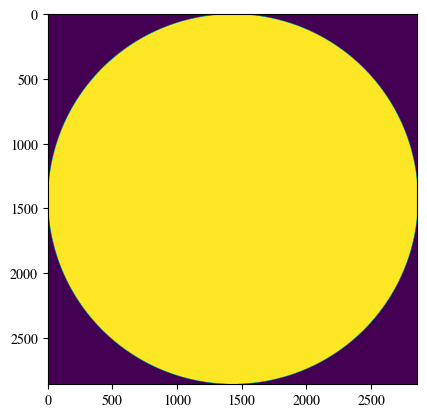

In [8]:
phasefield_center, aperture_center = generate_hyperboloid_phase_mask(periodicity=0.0056, semi_diameter=8, wavelength=4.50e-3, f=356)

## Show the center aperture's phasefield
plt.imshow(phasefield_center)
plt.show()

## Show the center aperture's transmission
plt.imshow(aperture_center)
plt.show()

## Save the two datas above
np.save(os.path.join(folder_path, "center_aperture_transmission.npy"), aperture_center)
np.save(os.path.join(folder_path, "center_aperture_with_hyperboloid_phase_grid_5.6um.npy"), phasefield_center)

In [9]:
phasefield_center.shape

(2858, 2858)

In [10]:
aperture_center.shape

(2858, 2858)

Golay Aperture (8 mm sub-aperture radius, 44.5 mm outer radius, Golay_6+1 configuration)

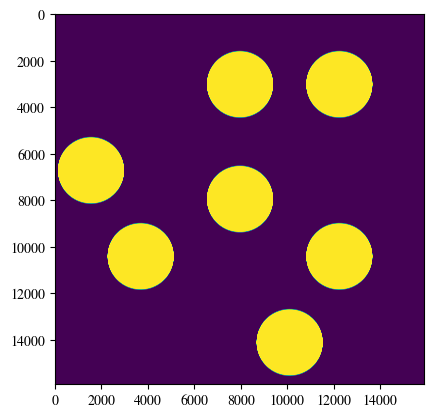

In [11]:
## Show and save the Golay aperture's transmission
_, aperture_golay = golay(order = 6, r = 8, circumradius = 44.5, dx = 0.0056, add_center = True)
plt.imshow(aperture_golay)
np.save(os.path.join(folder_path, "golay_aperture_transmission.npy"), aperture_golay)

Add the hyperboloid phase into the aperture

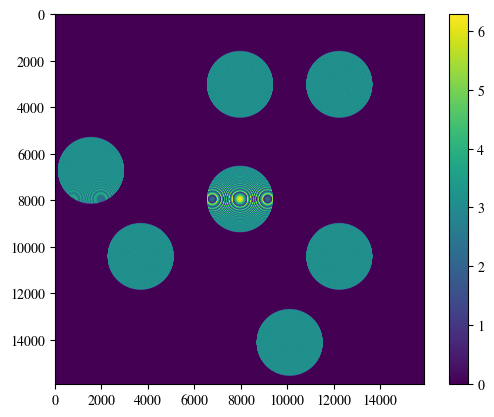

In [12]:
phasefield_golay, _ = generate_hyperboloid_phase_mask(periodicity=periodicity, semi_diameter=aperture_golay.shape[0]*periodicity/2, wavelength=4.50e-3, f=356)
phasefield_golay = phasefield_golay * aperture_golay

## Show and save the Golay aperture's phasefield
plt.imshow(phasefield_golay)
plt.colorbar()
plt.show()

np.save(os.path.join(folder_path, f"golay_with_hyperboloid_phase_grid_{periodicity*1e3}_um.npy"), phasefield_golay)

In [13]:
phasefield_golay.shape

(15894, 15894)

In [14]:
aperture_golay.shape

(15894, 15894)